## Analyzing financial data to create an efficient portfolio with selected stocks

### Importing all the libraries

In [1]:
import pandas as pd
import cvxopt as opt
from cvxopt import blas, solvers
import seaborn as sn
import pandas_datareader as web
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Getting the stock data from the datareader into a dataframe

Air Products & Chemicals (APD), Google (GOOG), Amazon (AMZN), Walmart (WMT), Exxon (XOM), Berkshire Hathaway Class B (BRK-B), UnitedHealth Group (UNH), Prologis (PLD), Apple (AAPL), NextEra Energy (NEE)

In [2]:
symbols = ['APD', 'GOOG', 'AMZN', 'WMT', 'BRK-B', 'UNH', 'UPS', 'PLD', 'AAPL', 'NEE']
start_date = '2017-01-01'
end_date = '2022-01-01'
stock_data = web.get_data_yahoo(symbols, start_date, end_date)
print(stock_data['Adj Close'].head())

Symbols            APD       GOOG       AMZN        WMT       BRK-B  \
Date                                                                  
2017-01-03  124.965157  39.306999  37.683498  61.311584  163.830002   
2017-01-04  126.054459  39.345001  37.859001  61.668774  164.080002   
2017-01-05  124.808281  39.701000  39.022499  61.802723  163.300003   
2017-01-06  125.801720  40.307499  39.799500  60.954403  163.410004   
2017-01-09  127.501083  40.332500  39.846001  61.356232  162.020004   

Symbols            UNH        UPS        PLD       AAPL        NEE  
Date                                                                
2017-01-03  147.823471  95.783951  45.421524  27.174759  25.823845  
2017-01-04  148.244644  95.808907  46.230167  27.144337  25.899975  
2017-01-05  148.491867  95.858864  46.247364  27.282375  25.884750  
2017-01-06  148.702423  96.050301  46.548466  27.586527  25.808617  
2017-01-09  148.281265  95.525909  46.195763  27.839214  25.743362  


### Adjusted closing price over time

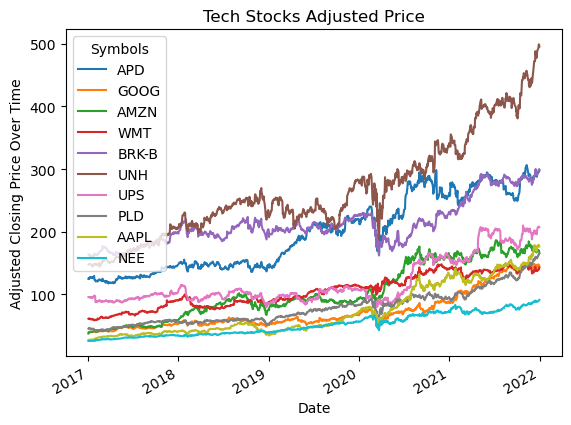

In [3]:
stock_data['Adj Close'].plot()
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price Over Time')
plt.title('Tech Stocks Adjusted Price')
plt.show()

In the past five years UnitedHealth Group (UNH) has significantly increased in price compared to other stocks.

### Mean rate of return

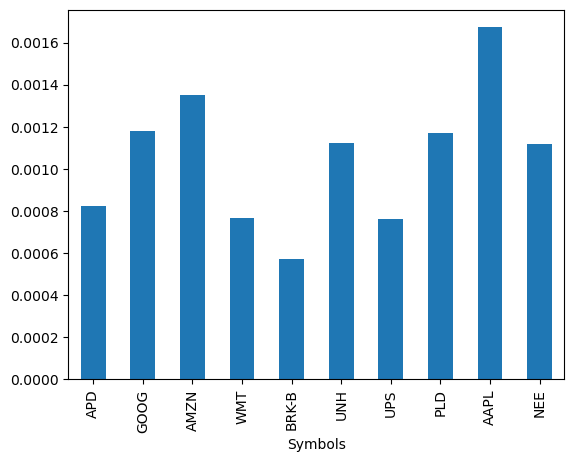

In [4]:
stock_data_daily_returns = stock_data['Adj Close'].pct_change()
stock_data_mean_returns = stock_data_daily_returns.mean()
stock_data_mean_returns.plot.bar()
plt.show()

### Finding out the covariance

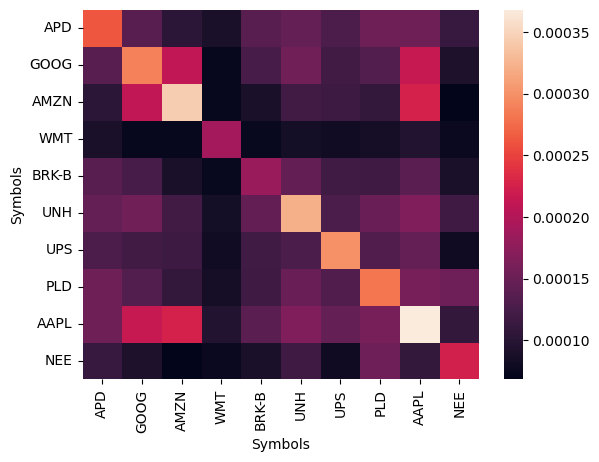

In [5]:
cov_daily = stock_data_daily_returns.cov()
sn.heatmap(cov_daily)
plt.show()

### Generating 5000 random portfolios using our stocks selection

In [6]:
#Function was imported from Codecademy

def return_portfolios(expected_returns, cov_matrix):
    port_returns = []
    port_volatility = []
    stock_weights = []
    
    selected = (expected_returns.axes)[0]
    
    num_assets = len(selected)
    num_portfolios = 5000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
        
    portfolio = {'Returns': port_returns, 'Volatility': port_volatility}
    
    for counter, symbol in enumerate(selected):
        portfolio[symbol + 'Weight'] = [Weight[counter] for Weight in stock_weights]
        
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+'Weight' for stock in selected]
    
    df = df[column_order]
    
    return df

       Returns  Volatility  APDWeight  GOOGWeight  AMZNWeight  WMTWeight  \
3714  0.001309    0.013639   0.024547    0.002774    0.236995   0.014185   
4349  0.001256    0.013328   0.117825    0.016398    0.038083   0.036100   
2551  0.001255    0.013198   0.059281    0.087893    0.193024   0.081753   
2212  0.001255    0.012811   0.021463    0.141510    0.127103   0.027630   
1065  0.001245    0.014091   0.051424    0.328236    0.224799   0.017885   
...        ...         ...        ...         ...         ...        ...   
1844  0.000873    0.011004   0.077999    0.143996    0.018658   0.229639   
4925  0.000872    0.011874   0.235043    0.080802    0.003088   0.138470   
2781  0.000872    0.011386   0.058978    0.037757    0.033130   0.147925   
106   0.000869    0.011770   0.200761    0.127226    0.024991   0.098594   
2740  0.000868    0.011227   0.127099    0.017885    0.022877   0.205286   

      BRK-BWeight  UNHWeight  UPSWeight  PLDWeight  AAPLWeight  NEEWeight  
3714     0.

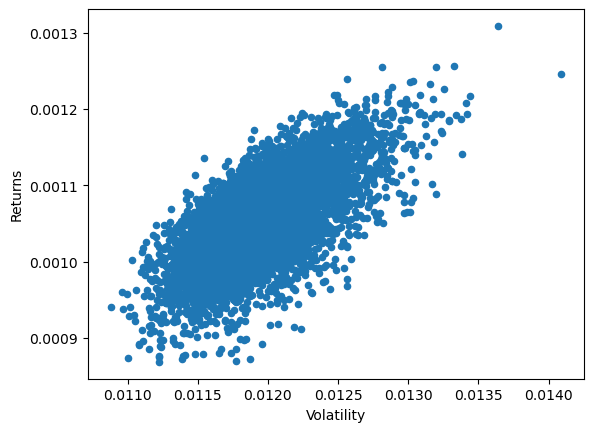

In [7]:
random_portfolios = return_portfolios(stock_data_mean_returns, cov_daily)
random_portfolios.plot.scatter(x='Volatility', y='Returns')
print(random_portfolios.sort_values(by=['Returns', 'Volatility'], ascending=[False, True]))

In [8]:
#Function imported from Codecademy

def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.values)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n)) # negative n x n identity matrix
    h = opt.matrix(0.0, (n,1))
    A = opt.matrix(1.0, (1,n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

In [9]:
weights, returns, risks = optimal_portfolio(stock_data_daily_returns[1:])

     pcost       dcost       gap    pres   dres
 0: -1.0482e-03 -1.0017e+00  1e+00  2e-16  3e+00
 1: -1.0484e-03 -1.1662e-02  1e-02  8e-17  4e-02
 2: -1.0655e-03 -1.7616e-03  7e-04  1e-16  2e-03
 3: -1.6274e-03 -2.0525e-03  4e-04  1e-16  7e-04
 4: -1.6504e-03 -1.6583e-03  8e-06  1e-16  1e-05
 5: -1.6542e-03 -1.6543e-03  8e-08  1e-16  1e-07
 6: -1.6543e-03 -1.6543e-03  8e-10  2e-16  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0474e-03 -1.0017e+00  1e+00  6e-17  3e+00
 1: -1.0476e-03 -1.1661e-02  1e-02  6e-17  4e-02
 2: -1.0647e-03 -1.7602e-03  7e-04  2e-16  2e-03
 3: -1.6254e-03 -2.0504e-03  4e-04  8e-16  7e-04
 4: -1.6482e-03 -1.6560e-03  8e-06  1e-16  1e-05
 5: -1.6520e-03 -1.6521e-03  8e-08  1e-16  1e-07
 6: -1.6520e-03 -1.6520e-03  8e-10  3e-17  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0465e-03 -1.0017e+00  1e+00  6e-17  3e+00
 1: -1.0466e-03 -1.1659e-02  1e-02  4e-17  4e-02
 2: -1.0637e-03 -1.7587e

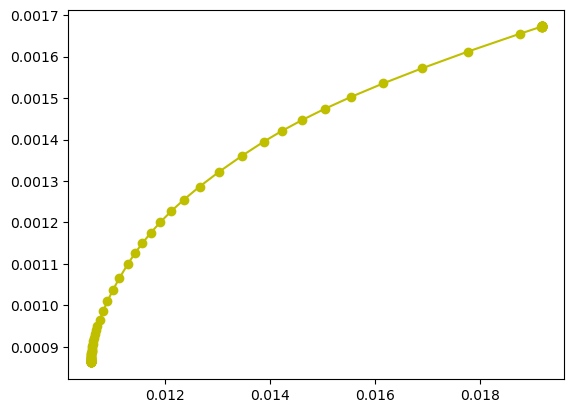

In [10]:
plt.plot(risks, returns, 'y-o')

### Top 5 selected stocks based on daily returns

In [11]:
selected = ['AAPL', 'AMZN', 'GOOG', 'PLD', 'UNH']
selected_stocks_daily_returns = stock_data['Adj Close'][selected].pct_change()
print(selected_stocks_daily_returns.head())

Symbols         AAPL      AMZN      GOOG       PLD       UNH
Date                                                        
2017-01-03       NaN       NaN       NaN       NaN       NaN
2017-01-04 -0.001120  0.004657  0.000967  0.017803  0.002849
2017-01-05  0.005085  0.030732  0.009048  0.000372  0.001668
2017-01-06  0.011148  0.019912  0.015277  0.006511  0.001418
2017-01-09  0.009160  0.001168  0.000620 -0.007577 -0.002832


In [12]:
selected_weights, selected_returns, selected_risks = optimal_portfolio(selected_stocks_daily_returns[1:])

     pcost       dcost       gap    pres   dres
 0: -1.2905e-03 -1.0017e+00  1e+00  3e-16  3e+00
 1: -1.2906e-03 -1.1660e-02  1e-02  6e-17  3e-02
 2: -1.2982e-03 -1.7596e-03  5e-04  4e-17  1e-03
 3: -1.6472e-03 -1.8238e-03  2e-04  3e-16  2e-04
 4: -1.6535e-03 -1.6560e-03  2e-06  1e-16  2e-06
 5: -1.6543e-03 -1.6543e-03  2e-08  2e-16  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2893e-03 -1.0017e+00  1e+00  2e-16  3e+00
 1: -1.2894e-03 -1.1658e-02  1e-02  1e-16  3e-02
 2: -1.2970e-03 -1.7580e-03  5e-04  1e-16  1e-03
 3: -1.6449e-03 -1.8212e-03  2e-04  3e-16  2e-04
 4: -1.6512e-03 -1.6537e-03  2e-06  5e-17  2e-06
 5: -1.6520e-03 -1.6521e-03  2e-08  1e-16  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2880e-03 -1.0017e+00  1e+00  2e-16  3e+00
 1: -1.2881e-03 -1.1656e-02  1e-02  1e-16  3e-02
 2: -1.2957e-03 -1.7562e-03  5e-04  7e-17  1e-03
 3: -1.6422e-03 -1.8182e-03  2e-04  4e-16  2e-04
 4: -1.6487e-03 -1.6512e

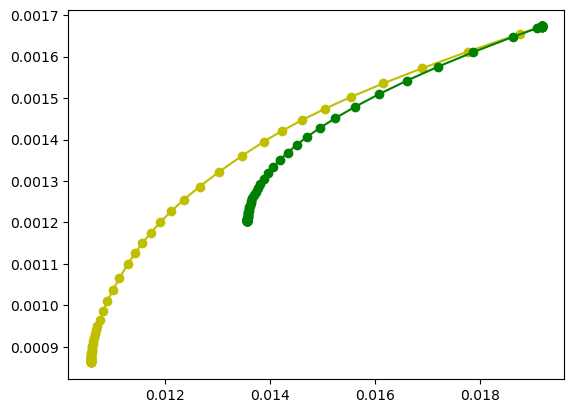

In [13]:
plt.plot(risks, returns, 'y-o')
plt.plot(selected_risks, selected_returns, 'g-o')

Selecting the top 5 performing stocks is only going to expose you to more risk for similar returns compared to a portfolio containing all 10 stocks.